In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pymc3
!{sys.executable} -m pip install arviz

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from IPython.display import Latex, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import arviz as az
import pymc3 as pm
from functions import generate_simulation_data, plot_posteriors

<p class="gap2">
<h1 style="font-weight: bold; color: #ed9041">The Causal Problem of Overexposure to Repetitive Ads<br>
</h1>

<h2 style="color: #667b83">Instrument Variables and PyMC3</h2>


<p class="gap05">  </p>
<h3 style="color: #459db9">Ruben Mak <br>
Principal Data Scientist and Discovery Cluster Lead at Greenhouse</h3>
<img src="images/pydata_eindhoven.jpeg">
</p>

## Short introduction

<p><img src="images/wpp_greenhouse.png"></p>

## Quickly some terminology
* impression: an ad is loaded once onto a webpage browsed by a user
* conversion: the desired outcome of an advertiser, for example online purchase or visiting a specific webpage on the advertiser's website
* frequency cap: a setting which determines the maximum amount of impressions a user can get of an ad

## Research question
* What is the optimal amount of impressions to maximize conversions?

* Why is this a bad research question?

## What does the data say?

<p><img src="images/some_plots.png"></p>

## What more does the data say?

<p><img src="images/more_plots.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_1.png"></p>

## Maybe we should draw a causal graph...

<p><img src="images/causal_graph_2.png"></p>

## Instrumental Variable Setup
* The golden standard, A/B test (Random Controlled Trial) doesn't work...
* But we can run a A/B/n test on the frequency cap.
* This is a perfect setting to apply instrumental variables!

## Let's complete our causal graph

<p><img src="images/causal_graph_3.png"></p>

In [3]:
max_cap = 7
max_impr = 7

base_conversion_probability = [0.015, 0.07, 0.07, 0.08, 0.125, 0.08, 0.04]
effects = [0.1, 0.06, 0.04, 0.025, 0.015, 0.01, 0.005]

P_potential_impressions = [0.27, 0.21, 0.19, 0.14, 0.08, 0.06, 0.05]
P_frequency_cap = [1 / max_cap] * max_cap

n_users = 10 ** 6

df = generate_simulation_data(P_potential_impressions,
                            P_frequency_cap,
                            base_conversion_probability,
                            effects,
                            n_users)

df['non_conversions'] = df['users'] - df['conversions']

In [4]:
df

users  conversions  non_conversions
frequency_cap impressions                                      
1             1            143543        22936           120607
2             1             38623         4462            34161
              2            103641        24643            78998
3             1             38197         4316            33881
              2             30201         7089            23112
              3             74439        20804            53635
4             1             38636         4462            34174
              2             30280         6873            23407
              3             27393         7254            20139
              4             47029        14609            32420
5             1             38693         4531            34162
              2             29793         6955            22838
              3             27058         7322            19736
              4             20053         6110            13943
              5             27439         8979            18460
6             1             38310         4375            33935
              2             29853         6856            22997
              3             27409         7485            19924
              4             19982         6167            13815
              5             11306         4175             7131
              6             15731         4915            10816
7             1             38367         4420            33947
              2             30099         6816            23283
              3             27148         7288            19860
              4             19919         6060            13859
              5             11370         4066             7304
              6              8575         2858             5717
              7              6913         1980             4933

In [5]:
df_impressions = df.groupby(['impressions']).sum()
df_impressions

,users,conversions,non_conversions
impressions,,,
1,374369,49502,324867
2,253867,59232,194635
3,183447,50153,133294
4,106983,32946,74037
5,50115,17220,32895
6,24306,7773,16533
7,6913,1980,4933


In [6]:
df_frequency_cap = df.groupby(['frequency_cap']).sum()
df_frequency_cap

,users,conversions,non_conversions
frequency_cap,,,
1,143543,22936,120607
2,142264,29105,113159
3,142837,32209,110628
4,143338,33198,110140
5,143036,33897,109139
6,142591,33973,108618
7,142391,33488,108903


## Single treatment single instrument calculation

<h1><center>$\beta = \frac{P(Y=1|Z=1)-P(Y=1|Z=0)}{P(X=1|Z=1)-P(X=1|Z=0)}$</center></h1>


## Calculation example

<p><img src="images/causal_graph_4.png"></p>

## Adjusted calculation

<h1><center>$\beta_i = \frac{P(Y=1|Z=i)-P(Y=1|Z=i-1)}{P(X=i|Z=i)-P(X=i|Z=i-1)}$</center></h1>

<h1><center>$P(X=i|Z=i-1) = 0$</center></h1>

<h1><center>$\beta_i = \frac{P(Y=1|Z=i)-P(Y=1|Z=i-1)}{P(X=i|Z=i)}$</center></h1>

<h1><center>$\delta_i = P(Y=1|Z=i)-P(Y=1|Z=i-1)$</center></h1>

<h1><center>$\beta_i = \frac{\delta_i}{P(X=i|Z=i)}$</center></h1>


In [7]:
n_samples = 10 ** 4

P_Y_given_X = [stats.beta.rvs(df_impressions['conversions'][i],
                                               df_impressions['non_conversions'][i],
                                               size = n_samples) for i in df_impressions.index]

P_Y_given_Z = [stats.beta.rvs(df_frequency_cap['conversions'][i],
                                               df_frequency_cap['non_conversions'][i],
                                               size = n_samples) for i in df_frequency_cap.index]

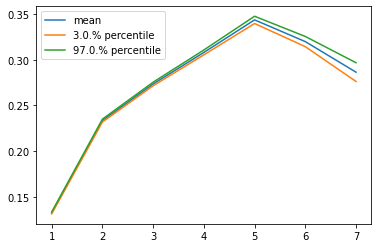

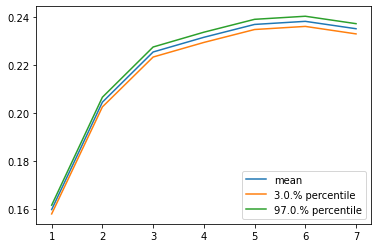

In [8]:
plot_posteriors(df_impressions.index, P_Y_given_X)
plot_posteriors(df_frequency_cap.index, P_Y_given_Z)

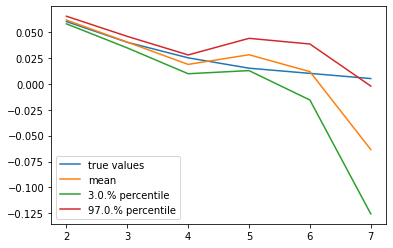

In [9]:
𝛿_P_Y_given_Z = [P_Y_given_Z[i] - P_Y_given_Z[i-1] for i in range(1, len(P_Y_given_Z))]

a = [df.loc[(i, i)].users for i in df_frequency_cap.index]
b = [df_frequency_cap.users[i+1] - a[i] for i in range(len(a))]

P_X_given_Z = [stats.beta.rvs(a[i], b[i], size = n_samples) for i in range(1, len(a))]

𝛽_effects = [𝛿_P_Y_given_Z[i] / P_X_given_Z[i] for i in range(len(𝛿_P_Y_given_Z))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects, effects[1:])

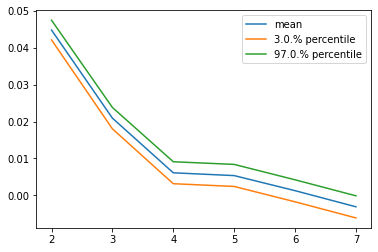

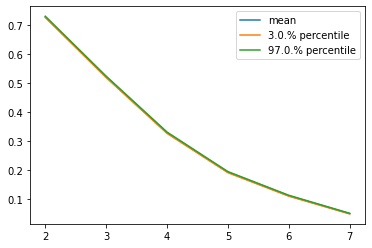

In [10]:
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z)
plot_posteriors(df_frequency_cap.index[1:], P_X_given_Z)

## Making Assumptions
* Core of modelling: variance / bias trade-off
* Let's make some assumptions on a parametric for for $\delta_i$


## Define our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha + $logit$^{-1}(c + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜃, 𝛼, c]


Sampling 4 chains for 10_000 tune and 2_500 draw iterations (40_000 + 10_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.6780513117094592, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 120579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 120572 missing f

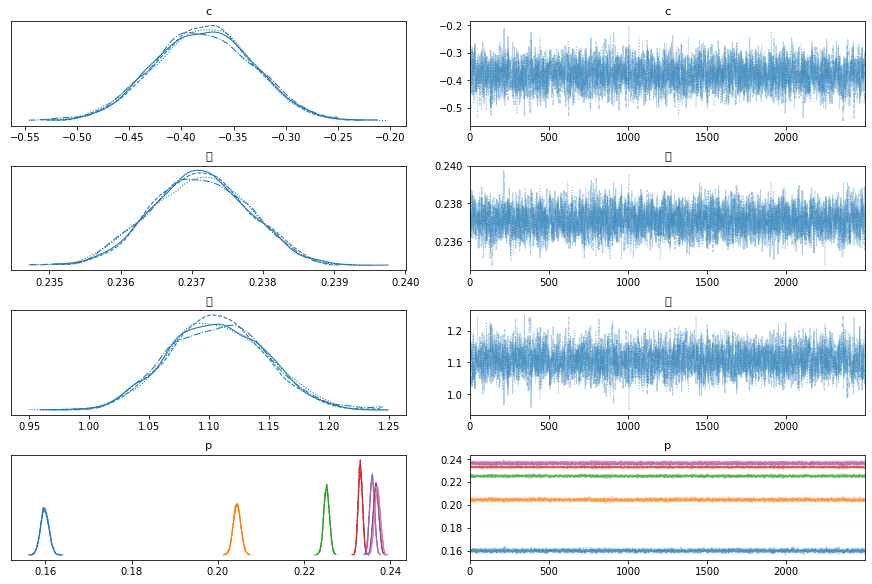

In [11]:
with pm.Model() as model_1:
    c = pm.Normal('c', mu=0, sigma=3)
    𝛼 = pm.HalfNormal('𝛼', sigma=0.25)
    𝜃 = pm.HalfNormal('𝜃', sigma=0.5)
    p = pm.Deterministic('p', 𝛼 * pm.math.invlogit(c + 𝜃 * df_frequency_cap.index))
    conversion = pm.Binomial('conversion', df_frequency_cap.users, p, observed=df_frequency_cap.conversions)
    model_1 = pm.sample(int(n_samples/4), tune=10000, chains=4, cores=4)
    pm.traceplot(model_1)

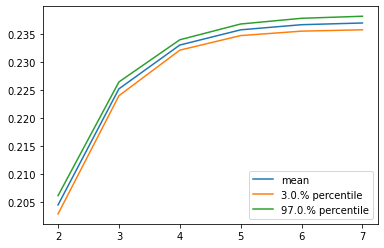

In [12]:
p_plot_1 = np.array(model_1['p']).T
plot_posteriors(df_frequency_cap.index[1:], p_plot_1[1:])

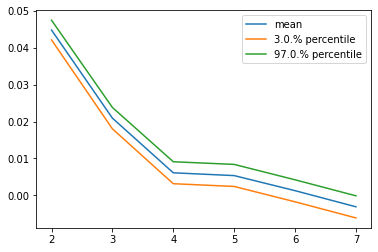

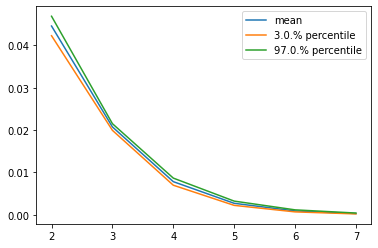

In [13]:
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z)
𝛿_P_Y_given_Z_1 = [p_plot_1[i] - p_plot_1[i-1] for i in range(1, len(p_plot_1))]
plot_posteriors(df_frequency_cap.index[1:], 𝛿_P_Y_given_Z_1)

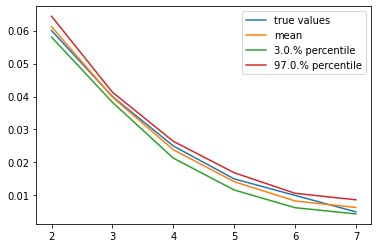

In [14]:
𝛽_effects_1 = [𝛿_P_Y_given_Z_1[i] / P_X_given_Z[i] for i in range(len(𝛿_P_Y_given_Z))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects_1, effects[1:])

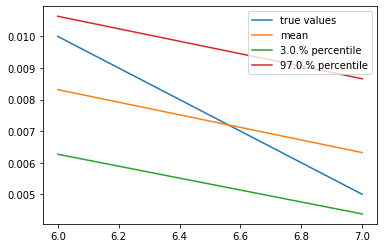

In [15]:
plot_posteriors(df_frequency_cap.index[5:7], 𝛽_effects_1[4:6], effects[5:7])

## Define our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha_Z + $logit$^{-1}(c + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $\alpha_Z \sim $Normal$(\alpha, 0.0001)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜃, 𝛼_z, c, 𝛼]


Sampling 4 chains for 10_000 tune and 2_500 draw iterations (40_000 + 10_000 draws total) took 90 seconds.
The acceptance probability does not match the target. It is 0.9157401742000546, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 120579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/rubenmak/Projects/pydata_eindhoven_2020_IV_frequency_cap/venv/freqcap_iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 120572 missing f

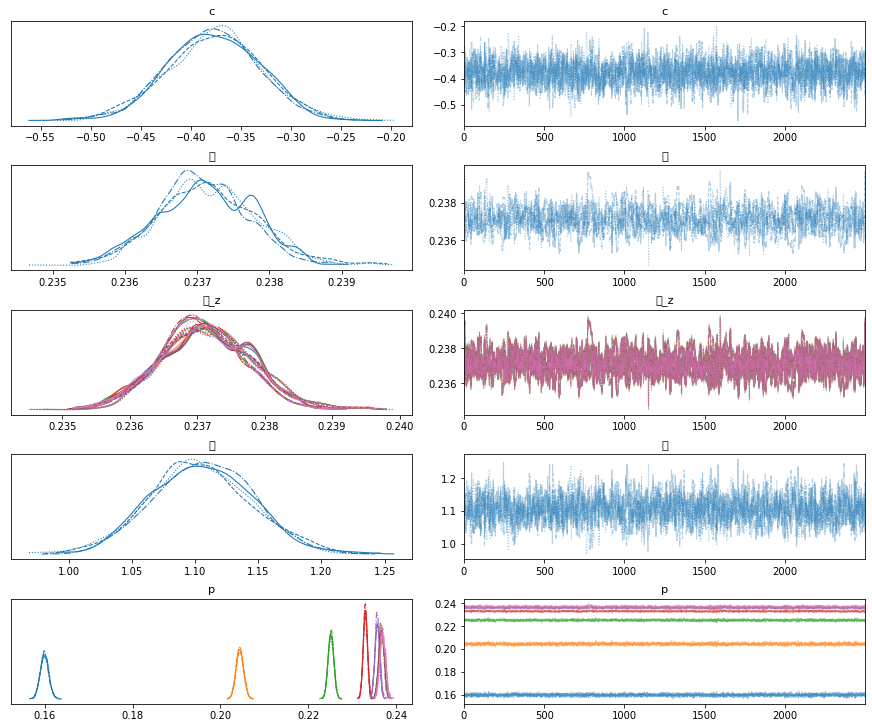

In [16]:
Y = df_frequency_cap.conversions
U = df_frequency_cap.users
Z = df_frequency_cap.index

with pm.Model() as model_2:
    𝛼 = pm.HalfNormal('𝛼', sigma=0.25)
    c = pm.Normal('c', mu=0, sigma=3)
    𝛼_Z = pm.Gamma('𝛼_z', mu=𝛼, sigma=0.0001, shape=max_cap)
    𝜃 = pm.HalfNormal('𝜃', sigma=0.5)
    p = pm.Deterministic('p', 𝛼_Z[range(max_impr)] * pm.math.invlogit(c + 𝜃 * Z))
    conversion = pm.Binomial('conversion', U, p, observed=Y)
    model_2 = pm.sample(int(n_samples/4), tune=10000, chains=4, cores=4)
    pm.traceplot(model_2)

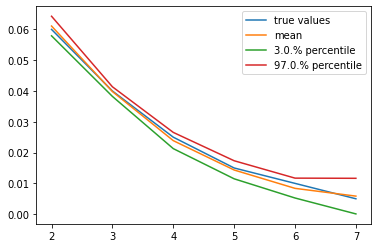

In [17]:
p_plot_2 = np.array(model_2['p']).T
𝛿_P_Y_given_Z_2 = [p_plot_2[i] - p_plot_2[i-1] for i in range(1, len(p_plot_2))]
𝛽_effects_2 = [𝛿_P_Y_given_Z_2[i] / P_X_given_Z[i] for i in range(len(𝛿_P_Y_given_Z_2))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects_2, effects[1:])

## Include hierarchy in our model

<h1><center>
    $Y \sim $Binomial$(U, P(Y|Z)$<br>
    $P(Y|Z) = \alpha + $logit$^{-1}(c_Z + \theta Z)$<br>
    $\alpha \sim $HalfNormal$(0.25)$<br>
    $c \sim $Normal$(0, 3)$<br>
    $\sigma_c \sim $HalfNormal$(0, 0.2)$<br>
    $c_Z \sim $Normal$(c, \sigma_c)$<br>
    $\theta \sim $HalfNormal$(0.5)$<br>
</center></h1>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜃, 𝛼, c_Z, 𝜎_c, c]


Sampling 4 chains for 10_000 tune and 2_500 draw iterations (40_000 + 10_000 draws total) took 53 seconds.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1625 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.03692639410365101, but should be close to 0.8. Try to increase the number of tuning steps.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.541144252891495, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1431 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.02822122504251471, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective s

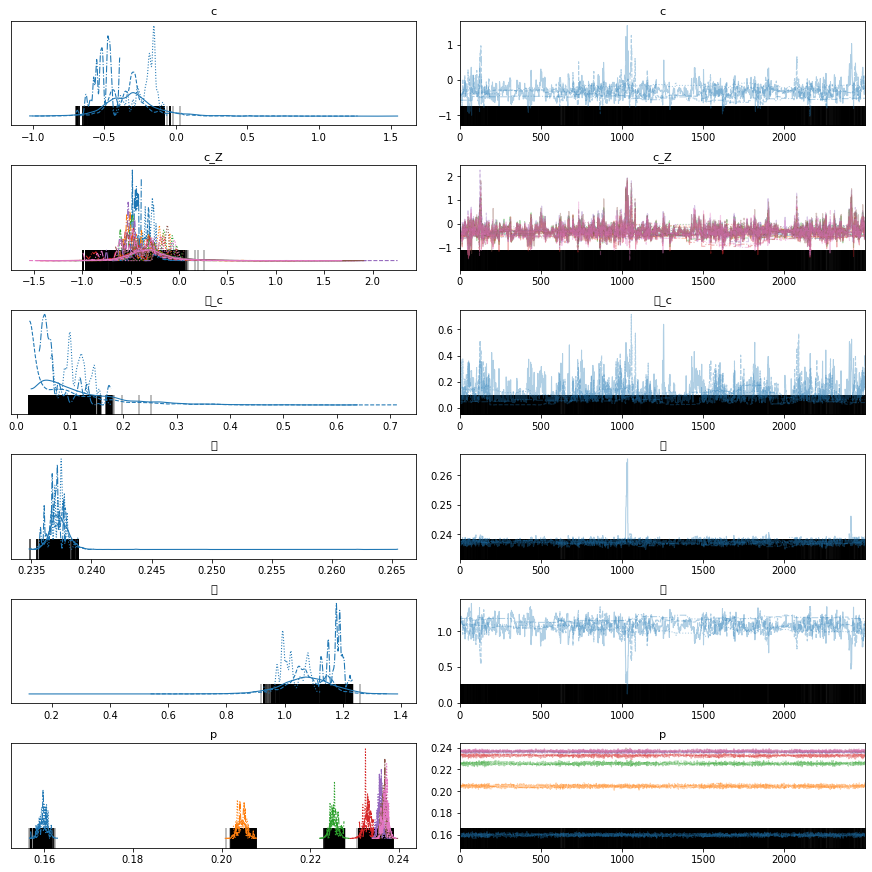

In [18]:
with pm.Model() as model_2:
    c = pm.Normal('c', mu=0, sigma=3)
    𝜎_c = pm.HalfNormal('𝜎_c', sigma=0.2)
    c_Z = pm.Normal('c_Z', mu=c, sigma=𝜎_c, shape=max_cap)
    𝛼 = pm.HalfNormal('𝛼', sigma=0.16)
    𝜃 = pm.HalfNormal('𝜃', sigma=0.5)
    p = pm.Deterministic('p', 𝛼 * pm.math.invlogit(c_Z[range(max_impr)] + 𝜃 * df_frequency_cap.index))
    conversion = pm.Binomial('conversion', df_frequency_cap.users, p, observed=df_frequency_cap.conversions)
    model_2 = pm.sample(int(n_samples/4), tune=10000, chains=4, cores=4)
    pm.traceplot(model_2)

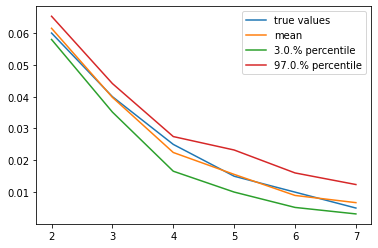

In [19]:
p_plot_2 = np.array(model_2['p']).T
𝛿_P_Y_given_Z_2 = [p_plot_2[i] - p_plot_2[i-1] for i in range(1, len(p_plot_2))]
𝛽_effects_2 = [𝛿_P_Y_given_Z_2[i] / P_X_given_Z[i] for i in range(len(𝛿_P_Y_given_Z_2))]

plot_posteriors(df_frequency_cap.index[1:], 𝛽_effects_2, effects[1:])

## Recap: when to use instrumental variables
* You need to have unbiased estimates of causal effects
* You can't A/B test the treatment of interest
* You can run an A/B test something that influences the treatment of interest, but not the outcome directly
* You're sure you don't just need the results of the A/B tests

## Conclusion
* Instrumental variables can be applied to quite specific setups
* You can guaranteed unbiased estimates of causal effects for something you can't A/B test
* When you run into problems with variance, you can start modelling by making parametric assumptions
* Hierachical modelling can be used to soften assumptions, to be continued in part 2 at PyMCon

## Questions?

In [ ]:
!jupyter nbconvert instrumental_variable_frequency_cap.ipynb --to slides --post serve

[NbConvertApp] Converting notebook instrumental_variable_frequency_cap.ipynb to slides
[NbConvertApp] Writing 894833 bytes to instrumental_variable_frequency_cap.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/instrumental_variable_frequency_cap.slides.html
Use Control-C to stop this server
